In [ ]:
!pip install torchtext==0.6.0 --quiet
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Dataset.zip

Archive:  /content/drive/MyDrive/Dataset.zip
   creating: Dakshina Dataset/
   creating: Dakshina Dataset/hi/
   creating: Dakshina Dataset/hi/lexicons/
  inflating: Dakshina Dataset/hi/lexicons/hi.translit.sampled.dev.tsv  
  inflating: Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv  
  inflating: Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv  


In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np

# Instantiates the device to be used as GPU/CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random
PATH_TO_DATA ="/content/Dakshina Dataset/hi/lexicons"

In [ ]:
# storing all the alphabets of English and the pad char to a dictionary to create OHE representation later.
eng_alphabets = 'abdcefghijklmnopqrstuvwxyz'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'a': 1, 'b': 2, 'd': 3, 'c': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [ ]:

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [ ]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

# Remove all English non-letters
def cleanEnglishVocab(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()
    line = non_eng_letters_regex.sub('', line)
    return line.split()

# Remove all Hindi non-letters
def cleanHindiVocab(line):
    line = line.replace('-', ' ').replace(',', ' ')
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char
    return cleaned_line.split()

In [ ]:
from torch.utils.data import Dataset
import csv
import re

class TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readDataset(filename, cleanHindiVocab)
       
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0
        
    def __len__(self):
        return len(self.eng_words)
    
    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]
    
    def readDataset(self, filename, lang_vocab_cleaner):
        
        with open(filename, newline='', encoding='utf-8') as csvfile:
            reader = csv.reader(csvfile)
            lang1_words = []
            lang2_words = []
            for row in reader:

                string_row=row[0]
                string_row=re.split(r'\t+', string_row)
               
                wordlist1 = string_row[0]

                
                wordlist2  = string_row[1]

              
                lang1_words.append(wordlist1)
              
                lang2_words.append(wordlist2)
                
            return lang2_words, lang1_words        
         
    def get_batch_from_array(self, batch_size, array): 
        end = self.shuffle_start_index + batch_size # what index till i want to go.
        batch = []
        if end >= len(self.eng_words): # if we overflow the words array , we have to loop back.
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]
    
    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1
        
        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
            
        return eng_batch, hindi_batch

In [ ]:
train_data = TransliterationDataLoader("/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.train.tsv")
test_data = TransliterationDataLoader("/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv")
val_data = TransliterationDataLoader("/content/Dakshina Dataset/hi/lexicons/hi.translit.sampled.test.tsv")

# LSTM model




In [ ]:

class Encoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size,num_layers=1, p =1 , verbose=False):
    super(Encoder,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers=num_layers
    self.dropout= nn.Dropout(p)
    self.embedding= nn.Embedding(input_size,embedding_size)
    self.block=nn.LSTM(embedding_size, hidden_size,num_layers, dropout=p)
  def forward(self,x):
    embedding= self.dropout(self.embedding(x))
    outputs, (hidden,cell)=self.block(embedding)
    return hidden,cell


In [ ]:
class decoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size,output_size,num_layers=1, p =1 , verbose=False):
    super(decoder,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers=num_layers
    self.dropout= nn.Dropout(p)
    self.embedding= nn.Embedding(input_size,embedding_size)
    self.block=nn.LSTM(embedding_size, hidden_size,num_layers, dropout=p)
    self.fc=nn.Linear(hidden_size, output_size)
  def forward(self,x,hidden,cell):
    x=x.unsqueeze(0)
    embedding= self.dropout(self.embedding(x))
    #print(embedding.shape)
    #print(hidden.shape)
    #print(cell.shape)
    outputs, (hidden,cell)=self.block(embedding,(hidden,cell))
    predictions= self.fc(outputs)
    predictions=predictions.squeeze(0)
    return predictions, hidden,cell

In [ ]:
class trans(nn.Module):
  def __init__(self, encoder, decoder):
    super(trans,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
  def forward(self,source,target,teacher_force_ratio=0.05):
    batch_size=source.shape[1]

    target_len = target.shape[0] 
    
    target_vocab_size = 128
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) 
    hidden, cell = self.encoder(source)
    x = target[0]
    for t in range(1, target_len):
        output, hidden, cell = self.decoder(x, hidden, cell)
        
        outputs[t] = output
        best_guess = output.argmax(1)
        x = target[t] if random.random() < teacher_force_ratio else best_guess
        
  
    return outputs 


# LSTM set 1




*   Input embedding size: 16
*   number of encoder layers: 1
* number of decoder layers: 1
*hidden layer size: 16


In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=16
decoder_embedding_size=16
hidden_size = 16
num_layers = 1
enc_dropout = 1
dec_dropout = 1


In [ ]:
encoder_net=Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model = trans(encoder_net, decoder_net).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model, 'gurudvara', 'गुरुद्वारा')


<ipython-input-15-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

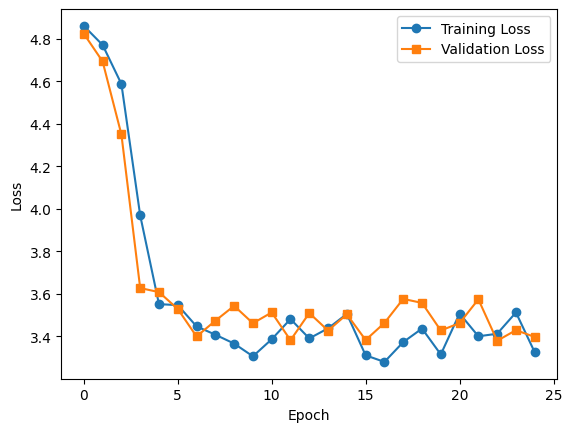

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

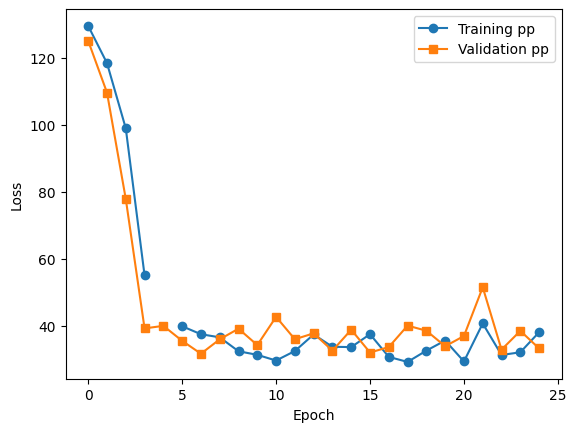

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

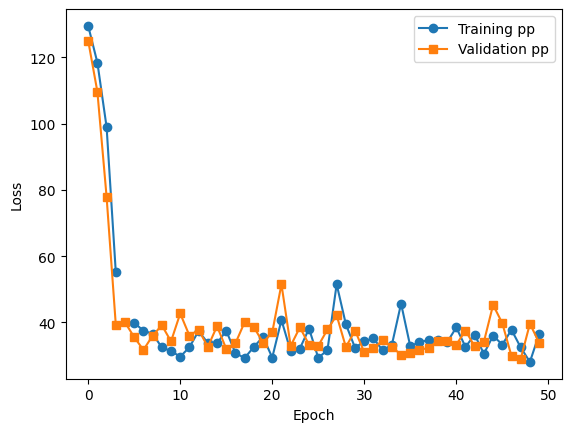

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

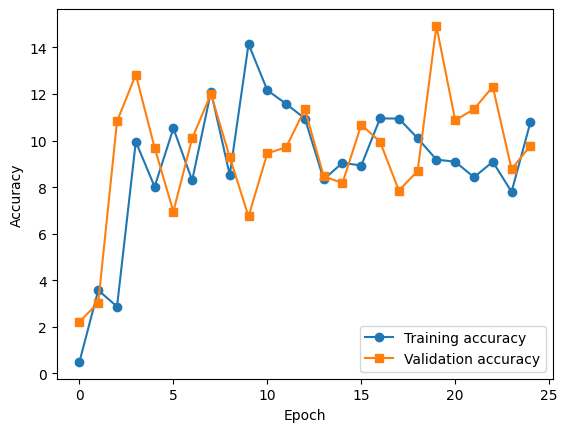

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-15-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  28.865510046482086


In [ ]:
100.*correct/total

10.989010989010989

# LSTM set 2



*   Input embedding size: 64
*   number of encoder layers: 3
* number of decoder layers: 3
*hidden layer size: 64



In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=64
decoder_embedding_size=64
hidden_size = 16
num_layers = 3
enc_dropout = 1
dec_dropout = 1


In [ ]:
encoder_net=Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model2 = trans(encoder_net, decoder_net).to(device)

In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model2, 'gurudvara', 'गुरुद्वारा')


<ipython-input-50-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model2.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model2(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model2(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






<ipython-input-50-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


tensor(4.8549, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  0
Epoch: 1 	Validation Loss: 4.796588 	Validation Accuracy: 0.00%
tensor(4.7334, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  1
Epoch: 2 	Validation Loss: 4.699467 	Validation Accuracy: 13.25%
tensor(4.5356, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  2
Epoch: 3 	Validation Loss: 4.369827 	Validation Accuracy: 7.69%
tensor(4.0572, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  3
Epoch: 4 	Validation Loss: 3.850755 	Validation Accuracy: 8.99%
tensor(3.7653, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  4
Epoch: 5 	Validation Loss: nan 	Validation Accuracy: 8.24%
tensor(3.5989, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  5
Epoch: 6 	Validation Loss: 3.455860 	Validation Accuracy: 12.02%
tensor(3.5815, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  6
Epoch: 7 	Validation Loss: 3.569250 	Validation Accuracy: 8.43%
tensor(3.5151, device='cuda:0', grad_fn=<DivBackward0>)  for epoc

In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

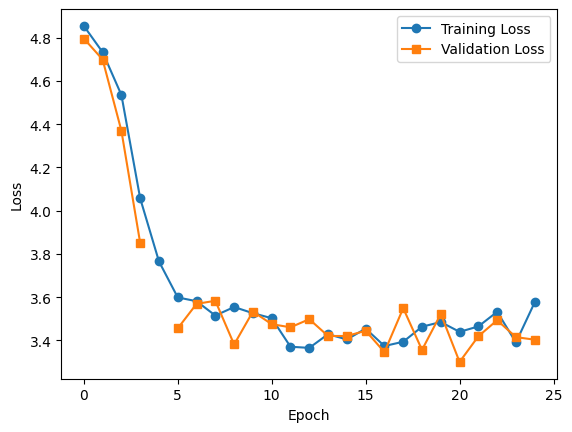

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

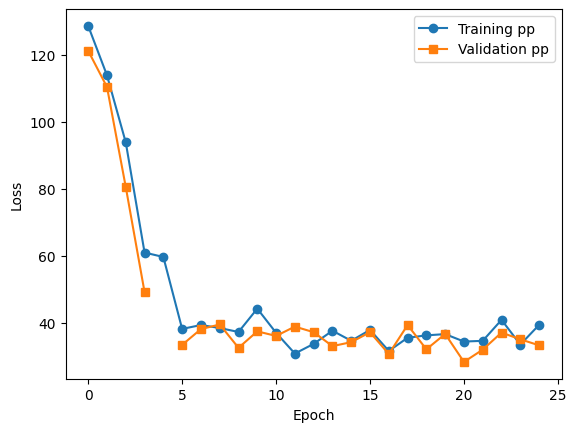

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

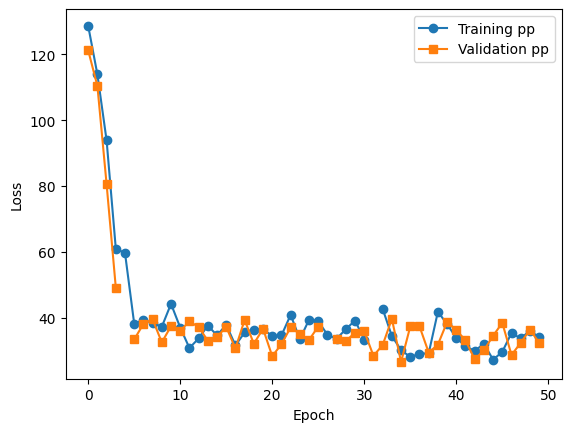

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

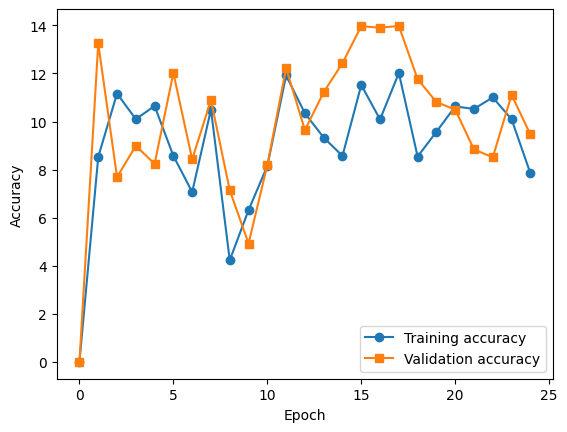

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model2(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-50-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  28.224501967430115


In [ ]:
100.*correct/total

13.089005235602095

# LSTM set 3




*   Input embedding size: 16
*   number of encoder layers: 1
* number of decoder layers: 1
*hidden layer size: 16
* dropout : 0.1



In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=16
decoder_embedding_size=16
hidden_size = 16
num_layers = 1
enc_dropout = 0.1
dec_dropout = 0.1


In [ ]:
encoder_net=Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model3 = trans(encoder_net, decoder_net).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model3, 'gurudvara', 'गुरुद्वारा')


<ipython-input-79-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model3.parameters(), lr=learning_rate)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model3.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model3(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model3(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






<ipython-input-79-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


tensor(4.8580, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  0
Epoch: 1 	Validation Loss: 4.811970 	Validation Accuracy: 2.66%
tensor(4.7842, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  1
Epoch: 2 	Validation Loss: 4.764684 	Validation Accuracy: 3.06%
tensor(4.7004, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  2
Epoch: 3 	Validation Loss: 4.642685 	Validation Accuracy: 2.17%
tensor(4.5155, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  3
Epoch: 4 	Validation Loss: 4.401802 	Validation Accuracy: 3.55%
tensor(4.1809, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  4
Epoch: 5 	Validation Loss: 3.932650 	Validation Accuracy: 7.65%
tensor(3.9061, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  5
Epoch: 6 	Validation Loss: 3.712445 	Validation Accuracy: 4.21%
tensor(3.6796, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  6
Epoch: 7 	Validation Loss: 3.677835 	Validation Accuracy: 8.99%
tensor(3.5779, device='cuda:0', grad_fn=<DivBackward0>)  for e

In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

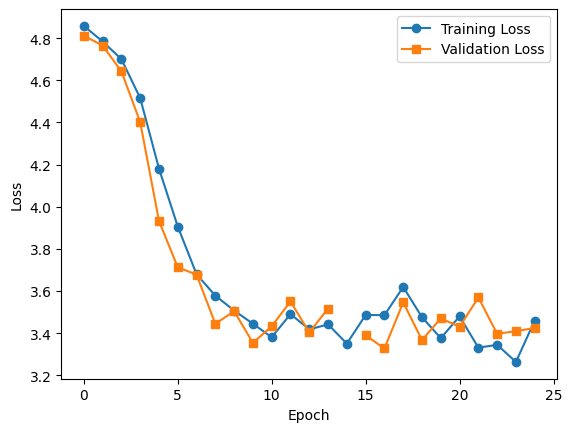

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

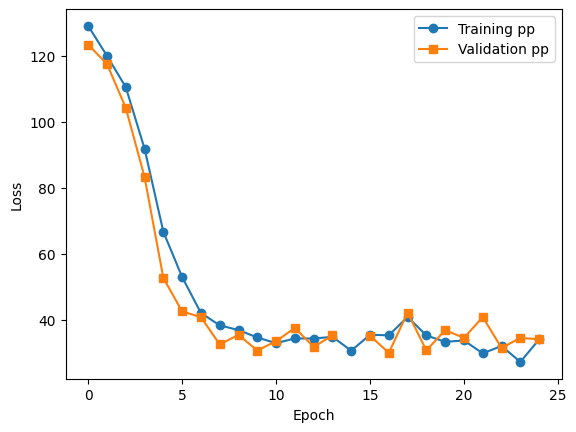

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

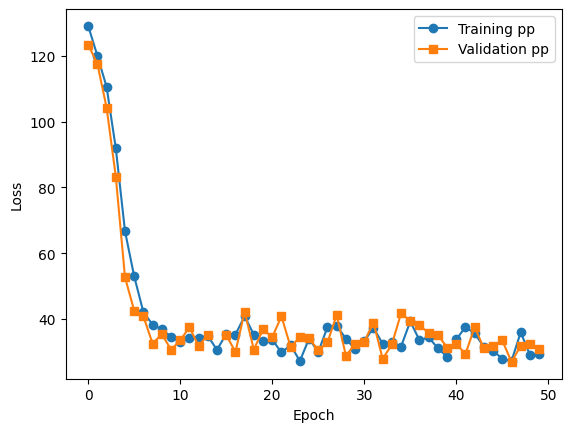

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

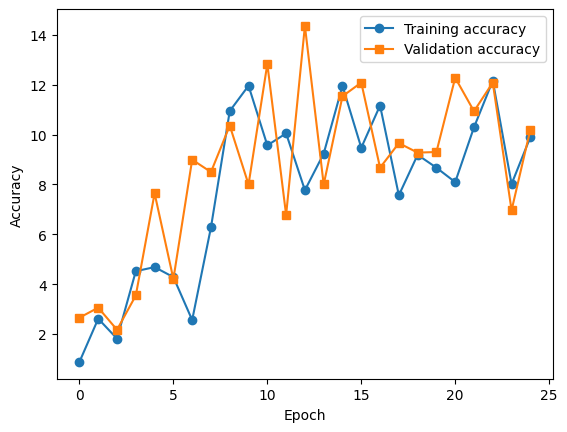

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model3(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-79-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  23.384103655815125


In [ ]:
100.*correct/total

14.285714285714286

# RNN model




In [ ]:

class Encoderr(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size,num_layers=1, p =1 , verbose=False):
    super(Encoderr,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers=num_layers
    self.dropout= nn.Dropout(p)
    self.embedding= nn.Embedding(input_size,embedding_size)
    self.block=nn.RNN(embedding_size, hidden_size,num_layers, dropout=p)
  def forward(self,x):
    embedding= self.dropout(self.embedding(x))
    outputs, hidden=self.block(embedding)
    return hidden


In [ ]:
class decoderr(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size,output_size,num_layers=1, p =1 , verbose=False):
    super(decoderr,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers=num_layers
    self.dropout= nn.Dropout(p)
    self.embedding= nn.Embedding(input_size,embedding_size)
    self.block=nn.RNN(embedding_size, hidden_size,num_layers, dropout=p)
    self.fc=nn.Linear(hidden_size, output_size)
  def forward(self,x,hidden):
    x=x.unsqueeze(0)
    embedding= self.dropout(self.embedding(x))
    outputs, hidden=self.block(embedding,(hidden))
    predictions= self.fc(outputs)
    predictions=predictions.squeeze(0)
    return predictions, hidden

In [ ]:
class transr(nn.Module):
  def __init__(self, encoder, decoder):
    super(transr,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
  def forward(self,source,target,teacher_force_ratio=0.05):
    batch_size=source.shape[1]

    target_len = target.shape[0] 
    
    target_vocab_size = 128
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) 
    hidden = self.encoder(source)
    x = target[0]
    for t in range(1, target_len):
        output, hidden = self.decoder(x, hidden)
        
        outputs[t] = output
        best_guess = output.argmax(1)
        x = target[t] if random.random() < teacher_force_ratio else best_guess
        
  
    return outputs 


# RNN set 1




*   Input embedding size: 16
*   number of encoder layers: 1
* number of decoder layers: 1
*hidden layer size: 16


In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=16
decoder_embedding_size=16
hidden_size = 16
num_layers = 1
enc_dropout = 1
dec_dropout = 1


In [ ]:
encoder_net=Encoderr(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decoderr(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model5 = transr(encoder_net, decoder_net).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model5, 'gurudvara', 'गुरुद्वारा')


<ipython-input-102-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model5.parameters(), lr=learning_rate)

In [ ]:
model5

transr(
  (encoder): Encoderr(
    (dropout): Dropout(p=1, inplace=False)
    (embedding): Embedding(27, 16)
    (block): RNN(16, 16, dropout=1.0)
  )
  (decoder): decoderr(
    (dropout): Dropout(p=1, inplace=False)
    (embedding): Embedding(128, 16)
    (block): RNN(16, 16, dropout=1.0)
    (fc): Linear(in_features=16, out_features=128, bias=True)
  )
)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model5.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model5(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model5.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model5(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






<ipython-input-102-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


tensor(4.7969, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  0
Epoch: 1 	Validation Loss: 4.755412 	Validation Accuracy: 0.00%
tensor(4.6830, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  1
Epoch: 2 	Validation Loss: 4.583227 	Validation Accuracy: 7.98%
tensor(4.4186, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  2
Epoch: 3 	Validation Loss: 4.244359 	Validation Accuracy: 11.28%
tensor(4.0668, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  3
Epoch: 4 	Validation Loss: 3.874884 	Validation Accuracy: 8.65%
tensor(3.8445, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  4
Epoch: 5 	Validation Loss: 3.483225 	Validation Accuracy: 12.17%
tensor(3.6395, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  5
Epoch: 6 	Validation Loss: 3.541081 	Validation Accuracy: 10.40%
tensor(3.6980, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  6
Epoch: 7 	Validation Loss: 3.546683 	Validation Accuracy: 11.28%
tensor(3.5756, device='cuda:0', grad_fn=<DivBackward0>)  f

In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

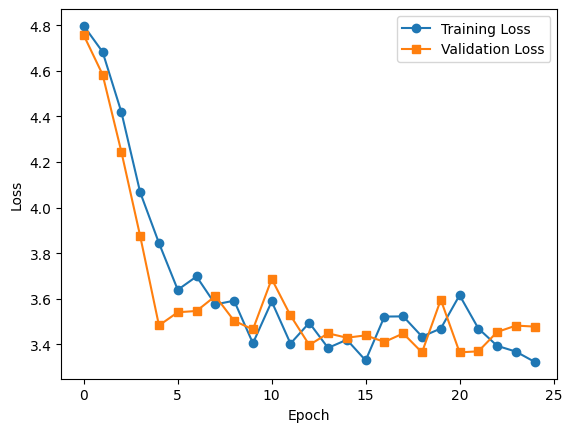

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

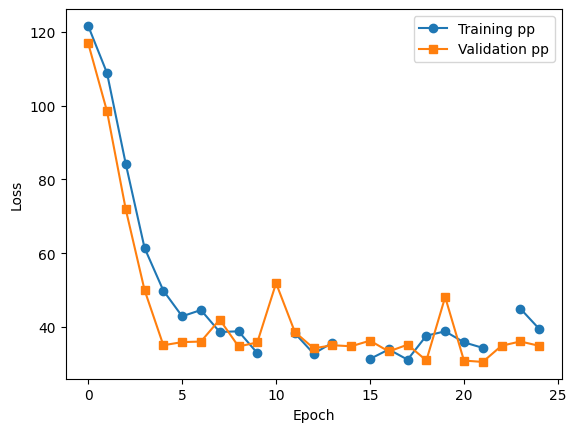

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

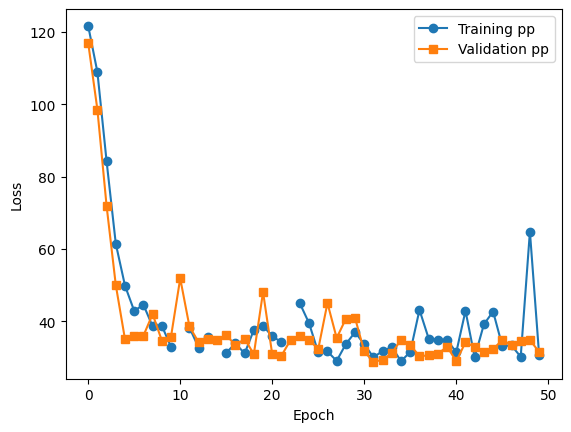

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

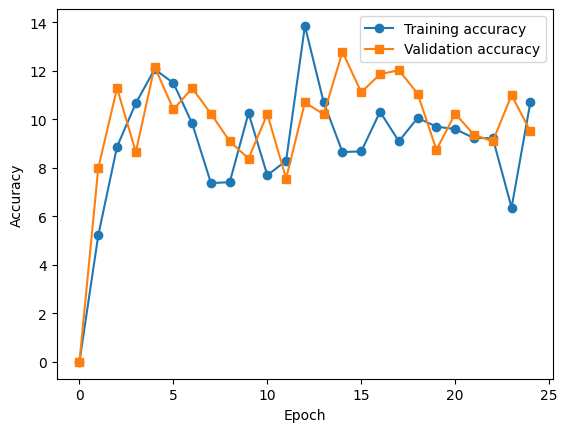

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model5(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-102-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  47.52447843551636


In [ ]:
100.*correct/total

9.090909090909092

# RNN set 2




*   Input embedding size: 64
*   number of encoder layers: 3
* number of decoder layers: 3
*hidden layer size: 64


In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=16
decoder_embedding_size=16
hidden_size = 64
num_layers = 3
enc_dropout = 1
dec_dropout = 1


In [ ]:
encoder_net=Encoderr(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decoderr(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model6 = transr(encoder_net, decoder_net).to(device)

In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model6, 'gurudvara', 'गुरुद्वारा')


<ipython-input-124-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model6.parameters(), lr=learning_rate)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model6.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model6(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model6(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






<ipython-input-124-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


tensor(4.6116, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  0
Epoch: 1 	Validation Loss: 4.235111 	Validation Accuracy: 6.52%
tensor(3.7144, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  1
Epoch: 2 	Validation Loss: 3.755932 	Validation Accuracy: 6.12%
tensor(3.5581, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  2
Epoch: 3 	Validation Loss: 3.526350 	Validation Accuracy: 11.18%
tensor(3.4533, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  3
Epoch: 4 	Validation Loss: 3.637538 	Validation Accuracy: 6.86%
tensor(3.4787, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  4
Epoch: 5 	Validation Loss: 3.546109 	Validation Accuracy: 8.89%
tensor(3.5118, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  5
Epoch: 6 	Validation Loss: 3.428331 	Validation Accuracy: 10.77%
tensor(3.4200, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  6
Epoch: 7 	Validation Loss: 3.414522 	Validation Accuracy: 10.26%
tensor(3.5092, device='cuda:0', grad_fn=<DivBackward0>)  fo

In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

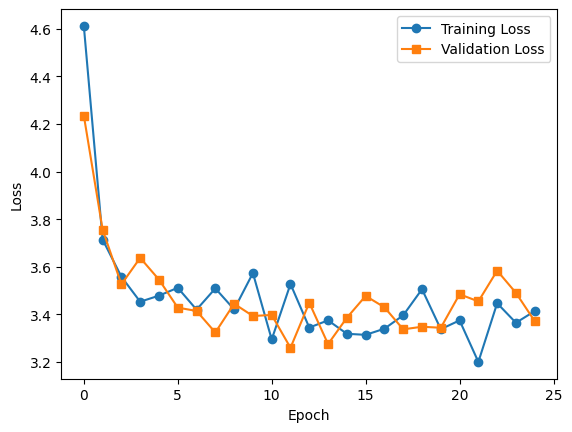

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

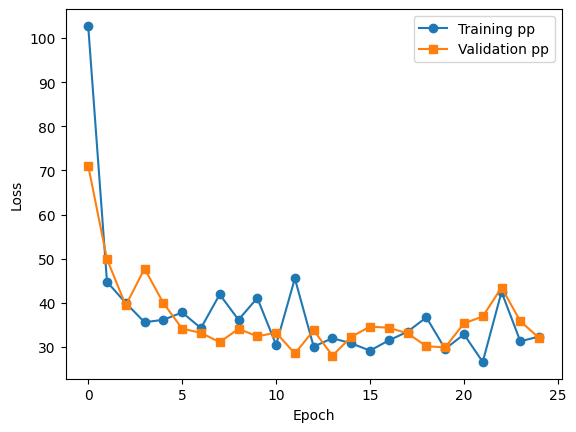

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

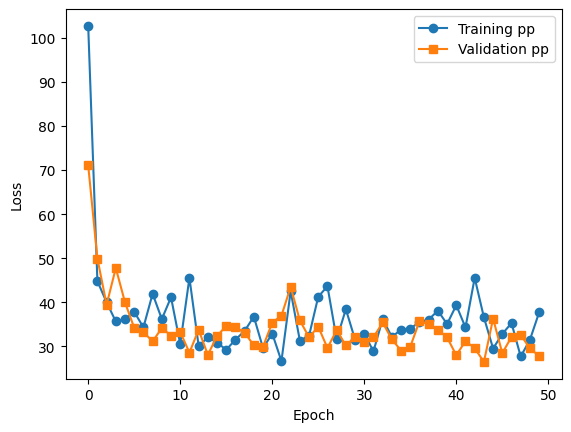

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

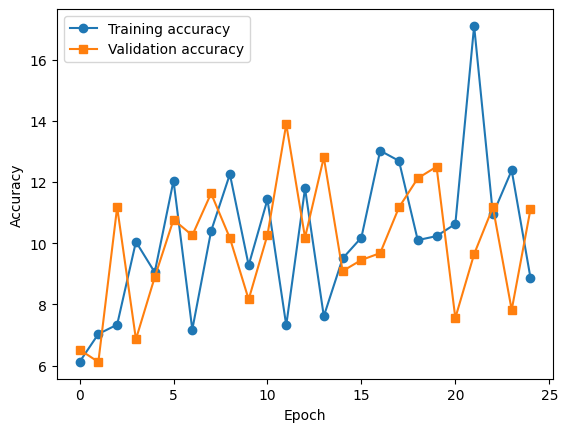

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model6(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-124-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  36.249361366033554


In [ ]:
100.*correct/total

10.112359550561798

# RNN set 3




*   Input embedding size: 16
*   number of encoder layers: 1
* number of decoder layers: 1
*hidden layer size: 16
* dropout=0.1(on both)



In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=16
decoder_embedding_size=16
hidden_size = 16
num_layers = 1
enc_dropout = 0.1
dec_dropout = 0.1


In [ ]:
encoder_net=Encoderr(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decoderr(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model5 = transr(encoder_net, decoder_net).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model5, 'gurudvara', 'गुरुद्वारा')


<ipython-input-144-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model5.parameters(), lr=learning_rate)

In [ ]:
model5

transr(
  (encoder): Encoderr(
    (dropout): Dropout(p=0.1, inplace=False)
    (embedding): Embedding(27, 16)
    (block): RNN(16, 16, dropout=0.1)
  )
  (decoder): decoderr(
    (dropout): Dropout(p=0.1, inplace=False)
    (embedding): Embedding(128, 16)
    (block): RNN(16, 16, dropout=0.1)
    (fc): Linear(in_features=16, out_features=128, bias=True)
  )
)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model5.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model5(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model5.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model5(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






<ipython-input-144-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


tensor(4.9028, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  0
Epoch: 1 	Validation Loss: 4.848208 	Validation Accuracy: 1.69%
tensor(4.8768, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  1
Epoch: 2 	Validation Loss: 4.694808 	Validation Accuracy: 1.18%
tensor(4.6971, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  2
Epoch: 3 	Validation Loss: 4.549470 	Validation Accuracy: 5.29%
tensor(4.5614, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  3
Epoch: 4 	Validation Loss: 4.355283 	Validation Accuracy: 2.79%
tensor(4.2869, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  4
Epoch: 5 	Validation Loss: 4.168439 	Validation Accuracy: 2.76%
tensor(4.1149, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  5
Epoch: 6 	Validation Loss: 3.924019 	Validation Accuracy: 3.57%
tensor(3.9136, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  6
Epoch: 7 	Validation Loss: 3.802967 	Validation Accuracy: 5.76%
tensor(3.7336, device='cuda:0', grad_fn=<DivBackward0>)  for e

In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

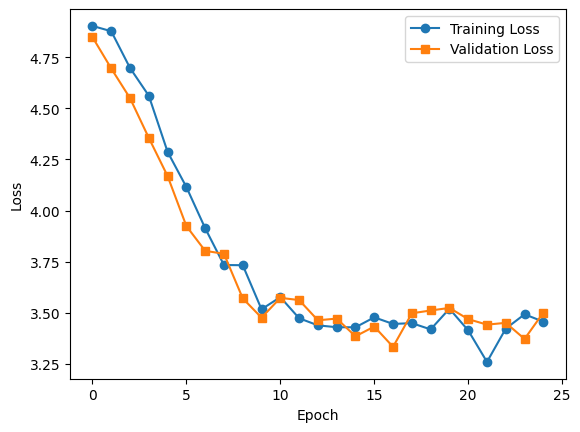

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

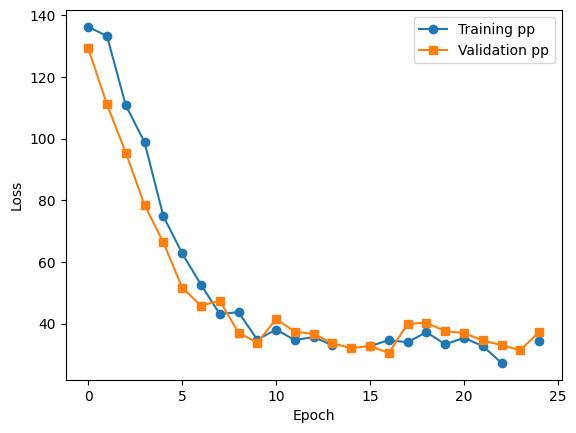

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

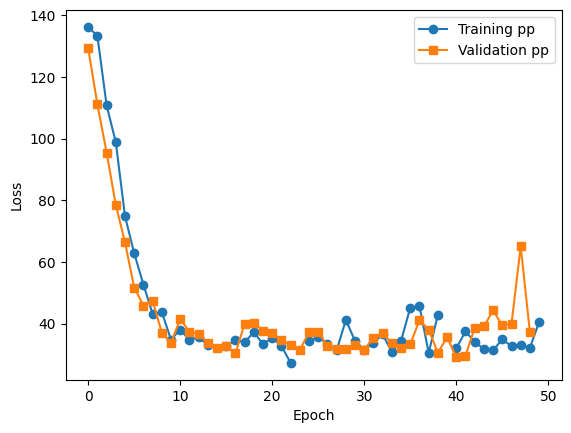

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

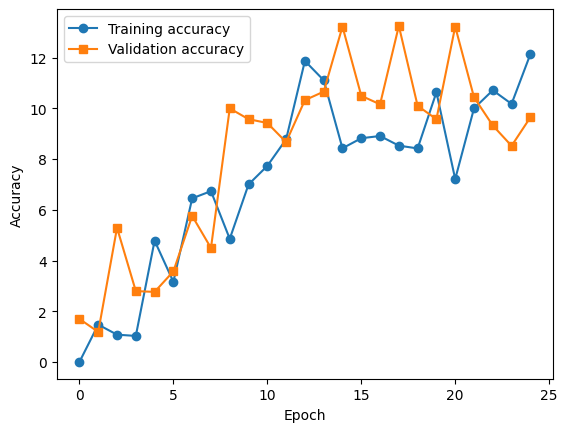

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model5(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-144-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  38.86574399471283


In [ ]:
100.*correct/total

11.11111111111111

# LSTM attention


In [ ]:

class Encodera(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size,num_layers=1, p =1 , verbose=False):
    super(Encodera,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers=num_layers
    self.dropout= nn.Dropout(p)
    self.embedding= nn.Embedding(input_size,embedding_size)
    self.block=nn.LSTM(embedding_size, hidden_size,num_layers,bidirectional=True ,dropout=p)
    self.fc_hidden=nn.Linear(hidden_size*2,hidden_size)
    self.fc_cell=nn.Linear(hidden_size*2,hidden_size)
  def forward(self,x):
    embedding= self.dropout(self.embedding(x))
    outputs, (hidden,cell)=self.block(embedding)
    hidden=self.fc_hidden(torch.cat((hidden[0:1],hidden[1:2]),dim=2))
    cell=self.fc_cell(torch.cat((cell[0:1],cell[1:2]),dim=2))
    return outputs,hidden,cell


In [ ]:
class decodera(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size,output_size,num_layers=1, p =1 , verbose=False):
    super(decodera,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers=num_layers
    self.dropout= nn.Dropout(p)
    self.embedding= nn.Embedding(input_size,embedding_size)
    self.block=nn.LSTM(hidden_size*2+embedding_size, hidden_size,num_layers, dropout=p)
    self.E=nn.Linear(hidden_size*3, 1)
    self.softmax=nn.Softmax(dim=0)
    self.relu=nn.ReLU()
    self.fc=nn.Linear(hidden_size, output_size)
  def forward(self,x,encoder_states,hidden,cell):
    x=x.unsqueeze(0)
    embedding= self.dropout(self.embedding(x))
    seq_len=encoder_states.shape[0]
    h_reshaped=hidden.repeat(seq_len,1,1)
    #print(embedding.shape)
    #print(hidden.shape)
    #print(cell.shape)
    energy=self.relu(self.E(torch.cat((h_reshaped,encoder_states),dim=2)))
    attention=self.softmax(energy)
    attention=attention.permute(1,2,0)
    encoder_states=encoder_states.permute(1,0,2)
    context=torch.bmm(attention,encoder_states).permute(1,0,2)
    block_input=torch.cat((context,embedding),dim=2)

    outputs, (hidden,cell)=self.block(block_input,(hidden,cell))
    predictions= self.fc(outputs)
    predictions=predictions.squeeze(0)
    return predictions, hidden,cell

In [ ]:
class transa(nn.Module):
  def __init__(self, encodera, decodera):
    super(transa,self).__init__()
    self.encoder=encodera
    self.decoder=decodera
  def forward(self,source,target,teacher_force_ratio=0.05):
    batch_size=source.shape[1]

    target_len = target.shape[0] 
    
    target_vocab_size = 128
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device) 
    encoder_states,hidden, cell = self.encoder(source)
    x = target[0]
    for t in range(1, target_len):
        output, hidden, cell = self.decoder(x,encoder_states, hidden, cell)
        
        outputs[t] = output
        best_guess = output.argmax(1)
        x = target[t] if random.random() < teacher_force_ratio else best_guess
        
  
    return outputs 


In [ ]:
##hyperparameters
num_epochs = 200
learning_rate=0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size_encoder= 27
input_size_decoder =128
output_size = 128
encoder_embedding_size=16
decoder_embedding_size=16
hidden_size = 16
num_layers = 1
enc_dropout = 0.1
dec_dropout = 0.1


In [ ]:
encoder_net=Encodera(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)
decoder_net=decodera(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout).to(device)
model7 = transa(encoder_net, decoder_net).to(device)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
def gt_tokens(word, letter2index, device = 'cpu'):
    gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return torch.tensor(gt_rep).squeeze()

In [ ]:
def infer(net, source_e,target_h):
    # net.eval()
    input = gt_tokens(source_e,eng_alpha2index)
    target=gt_tokens(target_h,hindi_alpha2index)
    input=input.unsqueeze(0)
    target=target.unsqueeze(0)
  
    
    target=target.t()
    input=input.t()
   
    outputs = net(input.to(device),target.to(device)) # initilise the hidden layer.
    
    return outputs

In [ ]:
out = infer(model7, 'gurudvara', 'गुरुद्वारा')


<ipython-input-193-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
out.shape

torch.Size([11, 1, 128])

In [ ]:
pad_idx=eng_alpha2index['-PAD-']

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

In [ ]:
optimizer = optim.Adam(model7.parameters(), lr=learning_rate)

In [ ]:
# def gt_rep(word, letter2index, device = 'cpu'):
#     gt_rep = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
#     for letter_index, letter in enumerate(word):
#         pos = letter2index[letter]
#         gt_rep[letter_index][0] = pos
#     gt_rep[letter_index+1][0] = letter2index[pad_char]
#     return torch.tensor(gt_rep.squeeze())

In [ ]:

losses=[]
val_loss=[]
val_accuracy=[]
accuracy=[]
perplexities=[]
val_p=[]
for epoch in range(num_epochs):
  model7.train()
  optimizer.zero_grad()
  eng_batch, hindi_batch = train_data.get_batch(batch_size)
  total_loss=0
  total_perplexity=0
  correct_a = 0
  total_a = 0
  for i in range(batch_size):
        input = gt_tokens(eng_batch[i],eng_alpha2index)
        target=gt_tokens(hindi_batch[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model7(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)

        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss
        perplexity = torch.exp(loss)
        total_perplexity += perplexity
        _, predicted = output.max(1)
        total_a += target.size(0)
        correct_a += predicted.eq(target).sum().item()

        torch.nn.utils.clip_grad_norm_(model5.parameters(), max_norm=1)

        optimizer.step()

  total_loss=total_loss/batch_size 
  total_perplexity=total_perplexity/batch_size
  print(total_loss, " for epoch ",epoch )
  losses.append(total_loss.item()) 
  perplexities.append(total_perplexity.item())
  accuracy.append(100.*correct_a/total_a)

  
  
    
  with torch.no_grad():
      eng_batch_val, hindi_batch_val = val_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      valid_p=0
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model7(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target).item()
        v_perplexity = torch.exp(criterion(output, target))
        valid_p=valid_p+v_perplexity.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

  # Print validation loss and accuracy
  val_loss.append(valid_loss/batch_size)
  val_accuracy.append(100.*correct/total)
  val_p.append(valid_p/batch_size)
  print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(
      epoch+1, valid_loss/batch_size, 100.*correct/total))






<ipython-input-193-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


tensor(4.8696, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  0
Epoch: 1 	Validation Loss: 4.856693 	Validation Accuracy: 0.00%
tensor(4.7997, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  1
Epoch: 2 	Validation Loss: 4.786875 	Validation Accuracy: 1.52%
tensor(4.6812, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  2
Epoch: 3 	Validation Loss: 4.580563 	Validation Accuracy: 5.71%
tensor(4.2265, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  3
Epoch: 4 	Validation Loss: 4.043708 	Validation Accuracy: 4.95%
tensor(3.7666, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  4
Epoch: 5 	Validation Loss: 3.739406 	Validation Accuracy: 10.24%
tensor(3.6051, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  5
Epoch: 6 	Validation Loss: 3.618259 	Validation Accuracy: 10.81%
tensor(3.5736, device='cuda:0', grad_fn=<DivBackward0>)  for epoch  6
Epoch: 7 	Validation Loss: 3.453392 	Validation Accuracy: 10.58%
tensor(3.4641, device='cuda:0', grad_fn=<DivBackward0>)  fo

In [ ]:
len(losses)

200

In [ ]:
def remove_nan_values(lst):
    return list(filter(lambda x: not (x != x), lst))

In [ ]:
losses=remove_nan_values(losses)

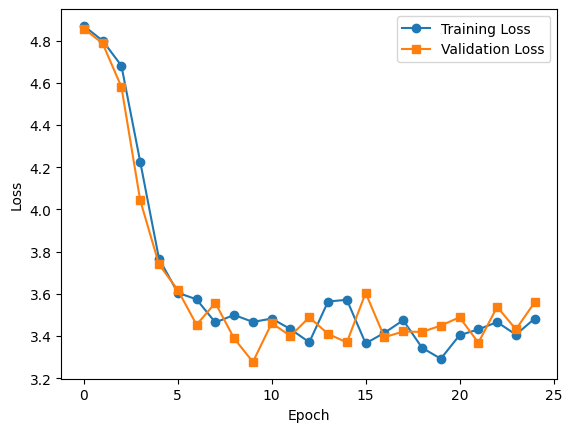

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(losses[:25], label='Training Loss', marker='o')
ax.plot(val_loss[:25], label='Validation Loss', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

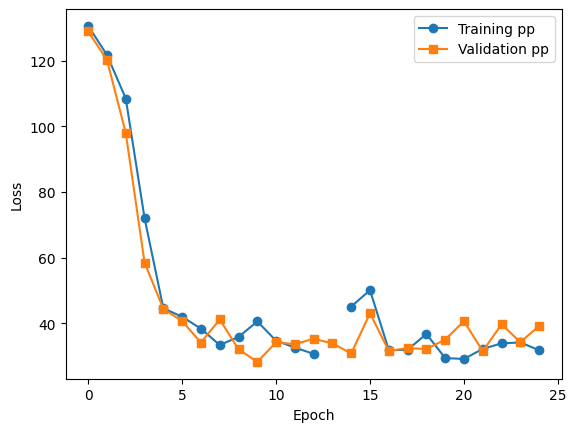

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:25], label='Training pp', marker='o')
ax.plot(val_p[:25], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

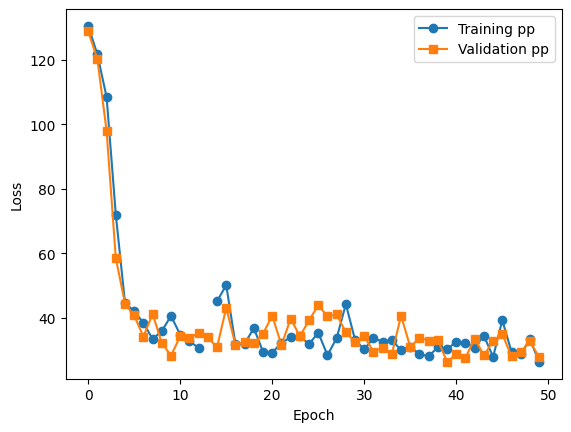

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(perplexities[:50], label='Training pp', marker='o')
ax.plot(val_p[:50], label='Validation pp', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

# Show the plot
plt.show()

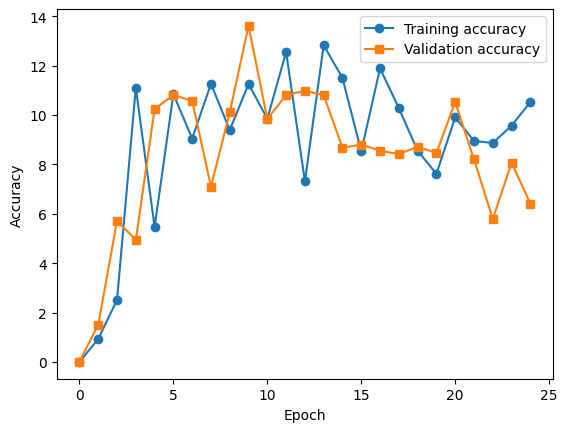

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the training and validation loss lists
ax.plot(accuracy[:25], label='Training accuracy', marker='o')
ax.plot(val_accuracy[:25], label='Validation accuracy', marker='s')

# Add a legend to the plot
ax.legend()

# Set the x-axis and y-axis labels
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

# Show the plot
plt.show()

In [ ]:
with torch.no_grad():
      eng_batch_val, hindi_batch_val = test_data.get_batch(batch_size)
      valid_loss = 0
      correct = 0
      total = 0
      p=0
  
      for i in range(batch_size):
        input = gt_tokens(eng_batch_val[i],eng_alpha2index)
        target=gt_tokens(hindi_batch_val[i],hindi_alpha2index)
        input=input.unsqueeze(0)
        target=target.unsqueeze(0)
        target=target.t()
        input=input.t()
        input,target=input.to(device),target.to(device)
        output = model7(input, target)
        output = output[1:].reshape(-1, output.shape[2])
        target = target[1:].reshape(-1)
        valid_loss += criterion(output, target)

        p=p+torch.exp(criterion(output, target)).item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

<ipython-input-193-941aa325935e>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(gt_rep).squeeze()


In [ ]:
print("Perplexity: ", p/batch_size)

Perplexity:  21.09592767804861


In [ ]:
100.*correct/total

15.675675675675675

# q2


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/household_power_consumption.zip

Archive:  /content/gdrive/MyDrive/household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# 80:20


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                 parse_dates={'DateTime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])

# Drop rows with missing values
df.dropna(inplace=True)

# Convert data types of relevant columns
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], downcast='float')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], downcast='float')
df['Voltage'] = pd.to_numeric(df['Voltage'], downcast='float')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], downcast='float')



# Print the first few rows of the preprocessed DataFrame
df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [ ]:
df.set_index('DateTime', inplace=True)

In [ ]:
import matplotlib.pyplot as plt


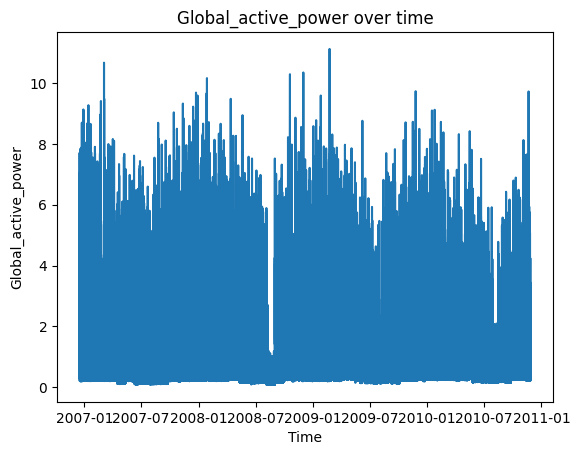

In [ ]:
plt.plot(df.Global_active_power)
plt.xlabel("Time")
plt.ylabel("Global_active_power")
plt.title("Global_active_power over time")
plt.savefig("initial_plot.png", dpi=1000)
plt.show();

In [ ]:
window_size=5

In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y2(df,window_size)
X1.shape, y1.shape

((2049275, 5, 7), (2049275,))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

#X_trans = ss.fit_transform(X1)
y1 = mm.fit_transform(y1.reshape(-1, 1))

In [ ]:
temp_training_mean = np.mean(X1[:, :, 0])
temp_training_std = np.std(X1[:, :, 0])
X1[:, :, 0] = (X1[:, :, 0] - temp_training_mean) / temp_training_std

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

def numpy_to_dataset(data, targets):
    dataset = MyDataset(data, targets)
    #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset

In [ ]:
train = numpy_to_dataset(X1[:int(len(X1)*0.8)], y1[:int(len(X1)*0.8)])
test= numpy_to_dataset(X1[int(len(X1)*0.8):], y1[int(len(X1)*0.8):])

In [ ]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

y = y.view(-1)

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 5, 7])
Target shape: torch.Size([64])


In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.lstm = nn.LSTM(num_sensors, hidden_units, batch_first=True)
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.linear(h[:, -1])
        return out.squeeze()

In [ ]:
learning_rate = 5e-4
num_hidden_units = 8

model = LSTM1(num_sensors=7, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        y = y.view(-1)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y = y.view(-1)
            output = model(X)
    
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()


loss=[]
test_loss=[]
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    loss.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    test_loss.append(test_model(test_loader, model, loss_function))
    print()

Untrained test
--------
Train loss: 0.155678478269131

Epoch 0
---------
Train loss: 0.0012337247305211135
Train loss: 0.00041707247489919185

Epoch 1
---------
Train loss: 0.0006351673048515395
Train loss: 0.0004223580398270957

Epoch 2
---------
Train loss: 0.0006274130189337594
Train loss: 0.00040110357913170823

Epoch 3
---------
Train loss: 0.0006231987667999946
Train loss: 0.0004155776455292663

Epoch 4
---------
Train loss: 0.0006137608346381381
Train loss: 0.0004038883350631437

Epoch 5
---------
Train loss: 0.0006075647278972272
Train loss: 0.00038592991248327343

Epoch 6
---------
Train loss: 0.0006034537063018613
Train loss: 0.0004108183550382345

Epoch 7
---------
Train loss: 0.0006015139338287332
Train loss: 0.0003881177229222465

Epoch 8
---------
Train loss: 0.0006010627964502103
Train loss: 0.00039560168291432826

Epoch 9
---------
Train loss: 0.000601120244519583
Train loss: 0.00038632958421906796



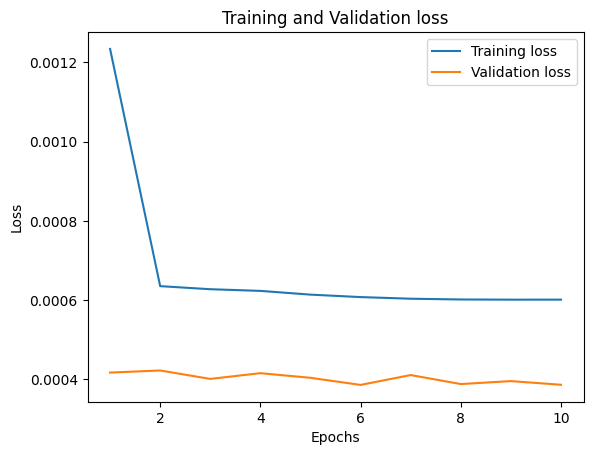

In [ ]:
import matplotlib.pyplot as plt

# define the training and validation loss lists


# create a range for the x-axis (epochs)
epochs = range(1, len(loss) + 1)

# plot the training and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Validation loss')

# add titles and labels to the plot
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# display the plot
plt.show()

In [ ]:
target=[]
predict=[]
model.eval()
total_loss=0
with torch.no_grad():
        for X, y in test:
            
            target.append(y)
            output = model(X.unsqueeze(0))
            predict.append(output.item())
            total_loss += loss_function(output, y).item()
    
print(total_loss)        

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


158.33907063776212


In [ ]:
actual_values=target
predicted_values=predict

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


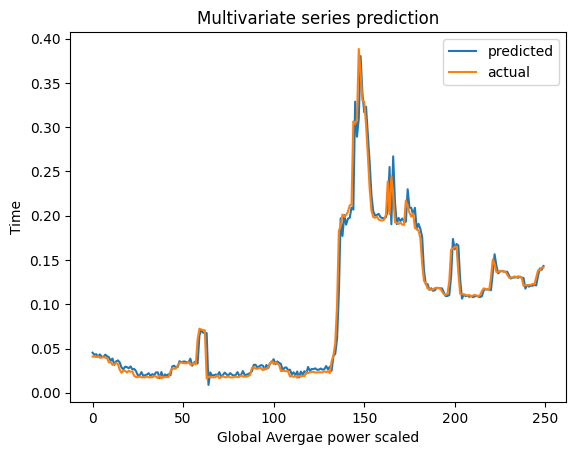

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predicted_values[:250],label="predicted")
plt.plot(actual_values[:250],label="actual")
plt.title('Multivariate series prediction')
plt.xlabel('Global Avergae power scaled')
plt.ylabel('Time')
plt.legend()
plt.show()

## 70:30


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                 parse_dates={'DateTime' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'])

# Drop rows with missing values
df.dropna(inplace=True)

# Convert data types of relevant columns
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], downcast='float')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], downcast='float')
df['Voltage'] = pd.to_numeric(df['Voltage'], downcast='float')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], downcast='float')



# Print the first few rows of the preprocessed DataFrame
df.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0


In [ ]:
df.set_index('DateTime', inplace=True)

In [ ]:
import matplotlib.pyplot as plt


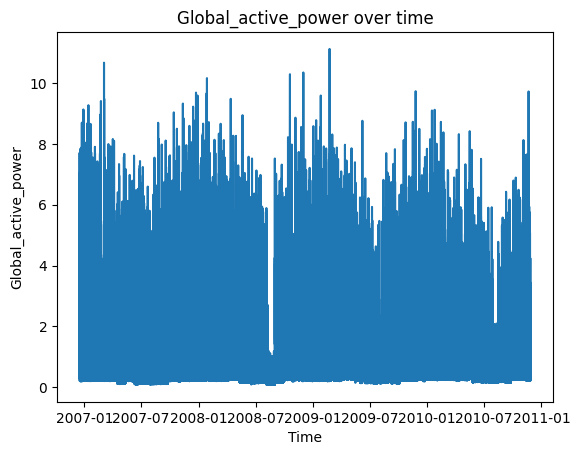

In [ ]:
plt.plot(df.Global_active_power)
plt.xlabel("Time")
plt.ylabel("Global_active_power")
plt.title("Global_active_power over time")
plt.savefig("initial_plot.png", dpi=1000)
plt.show();

In [ ]:
window_size=5

In [ ]:
def df_to_X_y2(df, window_size=6):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
X1, y1 = df_to_X_y2(df,window_size)
X1.shape, y1.shape

((2049275, 5, 7), (2049275,))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

#X_trans = ss.fit_transform(X1)
y1 = mm.fit_transform(y1.reshape(-1, 1))

In [ ]:
temp_training_mean = np.mean(X1[:, :, 0])
temp_training_std = np.std(X1[:, :, 0])
X1[:, :, 0] = (X1[:, :, 0] - temp_training_mean) / temp_training_std

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

def numpy_to_dataset(data, targets):
    dataset = MyDataset(data, targets)
    #dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataset

In [ ]:
train = numpy_to_dataset(X1[:int(len(X1)*0.7)], y1[:int(len(X1)*0.7)])
test= numpy_to_dataset(X1[int(len(X1)*0.7):], y1[int(len(X1)*0.7):])

In [ ]:
batch_size = 64
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

y = y.view(-1)

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([64, 5, 7])
Target shape: torch.Size([64])


In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
class LSTM1(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.lstm = nn.LSTM(num_sensors, hidden_units, batch_first=True)
        self.linear = nn.Linear(hidden_units, 1)

    def forward(self, x):
        h, _ = self.lstm(x)
        out = self.linear(h[:, -1])
        return out.squeeze()

In [ ]:
learning_rate = 5e-4
num_hidden_units = 8

model = LSTM1(num_sensors=7, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        y = y.view(-1)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y = y.view(-1)
            output = model(X)
    
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()


loss=[]
test_loss=[]
for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    loss.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    test_loss.append(test_model(test_loader, model, loss_function))
    print()

Untrained test
--------
Train loss: 0.18311924281299918

Epoch 0
---------
Train loss: 0.00082200170025817
Train loss: 0.00046470041532134407

Epoch 1
---------
Train loss: 0.0005942066708799706
Train loss: 0.0004445052620242772

Epoch 2
---------
Train loss: 0.0005841840307721079
Train loss: 0.0004246734659131423

Epoch 3
---------
Train loss: 0.0005766753717994254
Train loss: 0.0004189338106351792

Epoch 4
---------
Train loss: 0.0005717860732779151
Train loss: 0.00041545419096534905

Epoch 5
---------
Train loss: 0.0005695056127176918
Train loss: 0.00042286863232286347

Epoch 6
---------
Train loss: 0.0005686142081004784
Train loss: 0.0004210545898703377

Epoch 7
---------
Train loss: 0.0005679534631972317
Train loss: 0.00043416095989903055

Epoch 8
---------
Train loss: 0.0005667418612228327
Train loss: 0.00041603397027768844

Epoch 9
---------
Train loss: 0.0005662870089878193
Train loss: 0.0004327955037714706



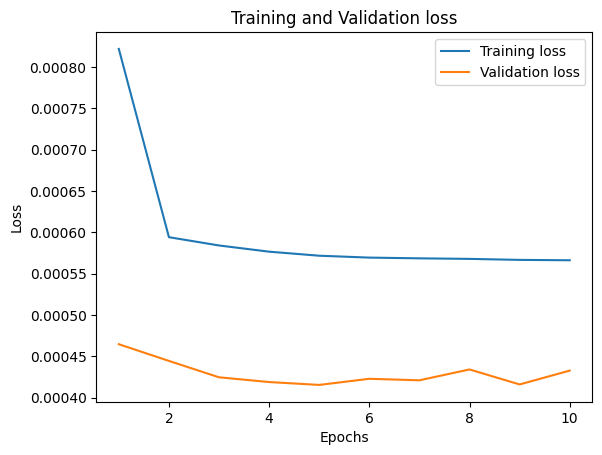

In [ ]:
import matplotlib.pyplot as plt

# define the training and validation loss lists


# create a range for the x-axis (epochs)
epochs = range(1, len(loss) + 1)

# plot the training and validation loss
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, test_loss, label='Validation loss')

# add titles and labels to the plot
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# display the plot
plt.show()

In [ ]:
target=[]
predict=[]
model.eval()
total_loss=0
with torch.no_grad():
        for X, y in test:
            
            target.append(y)
            output = model(X.unsqueeze(0))
            predict.append(output.item())
            total_loss += loss_function(output, y).item()
    
           

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
total_loss

266.0752071085376

In [ ]:
actual_values=target
predicted_values=predict

/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.9/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


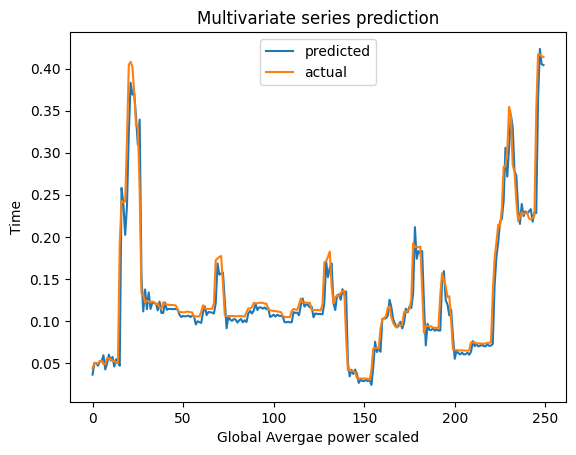

In [ ]:
import matplotlib.pyplot as plt
plt.plot(predicted_values[:250],label="predicted")
plt.plot(actual_values[:250],label="actual")
plt.title('Multivariate series prediction')
plt.xlabel('Global Avergae power scaled')
plt.ylabel('Time')
plt.legend()
plt.show()